In [1]:
!pip install -U --quiet transformers torch

In [26]:
import numpy as np
import pandas as pd
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import re

In [3]:
import kagglehub

dataset_path = kagglehub.dataset_download('lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')
csv_file = os.path.join(dataset_path, 'IMDB Dataset.csv')
df = pd.read_csv(csv_file)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
def clean_text(text):
  text = re.sub(r'<.*?>', '', text)
  text = text.lower()
  return text

In [5]:
df['review'] = df.review.apply(clean_text)

In [6]:
df['label'] = df.sentiment.map({'positive': 1, 'negative': 0})

In [7]:
df.head()

,review,sentiment,label
0,one of the other reviewers has mentioned that ...,positive,1
1,a wonderful little production. the filming tec...,positive,1
2,i thought this was a wonderful way to spend ti...,positive,1
3,basically there's a family where a little boy ...,negative,0
4,"petter mattei's ""love in the time of money"" is...",positive,1


In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df.label)

In [9]:
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (40000, 3)
Test shape: (10000, 3)


In [10]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
train_df = Dataset.from_pandas(train_df[['review', 'label']])
test_df = Dataset.from_pandas(test_df[['review', 'label']])

In [12]:
def tokenize_function(example):
  return tokenizer(example['review'], padding = 'max_length', truncation=True, max_length=256)

In [13]:
train_tokenized = train_df.map(tokenize_function, batched=True)
test_tokenized = test_df.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [22]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = 'weighted')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1': f1}

In [30]:
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 2,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 64,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = './logs',
    logging_steps=100
)

In [33]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_tokenized,
    eval_dataset = test_tokenized,
    compute_metrics = compute_metrics,
    tokenizer = tokenizer,
)

/tmp/ipython-input-3606433975.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [34]:
print("Starting model fine tuning with pytorch")
trainer.train()
print("Fine-tuning complete.")

Starting model fine tuning with pytorch


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ashish_kharde1 (ashish_kharde1-aissms-ioit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,0.682600
200,0.411300
300,0.348300
400,0.309500
500,0.332800
600,0.331600
700,0.304000
800,0.315600
900,0.296100
1000,0.293600


Fine-tuning complete.


In [35]:
output_dir = './assets/sentiment_distilert_pytorch'
os.makedirs(output_dir, exist_ok=True)
trainer.save_model(output_dir)
print("Model and tokenizer saved to", output_dir)

Model and tokenizer saved to ./assets/sentiment_distilert_pytorch


In [45]:
print("Evaluating model")
test_tokenized = test_tokenized.remove_columns(['review'])

predictions_output = trainer.predict(test_tokenized)
y_pred = np.argmax(predictions_output.predictions, axis=1)

y_true = test_tokenized['label']

Evaluating model


In [46]:
print("classification report:")
print(classification_report(y_true, y_pred, target_names = ['Negative', 'Positive']))

classification report:
              precision    recall  f1-score   support

    Negative       0.93      0.92      0.93      5000
    Positive       0.92      0.93      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000




Confusion Matrix:


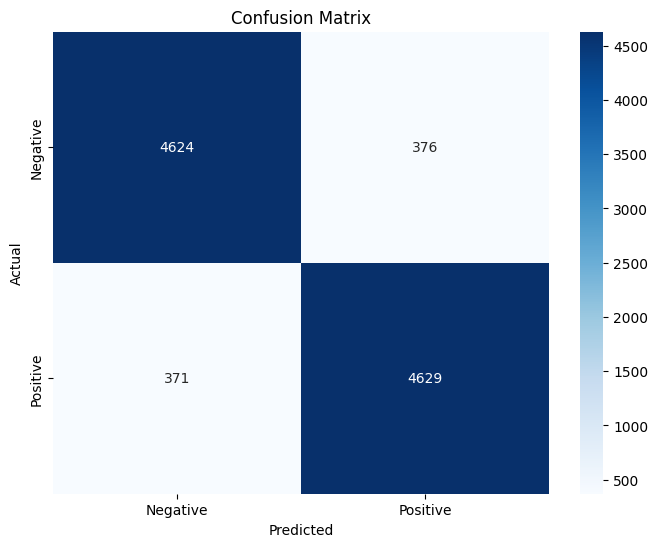

In [47]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()